# Add calculating time of flight for a matrix of arbitrary points

Extension upon the existing feature of adding a matrix of distance to origin.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
%matplotlib inline

In [2]:
xs = np.linspace(start=-1, stop=1, num=20)
ys = np.linspace(start=-1, stop=1, num=20)
xv, yv = np.meshgrid(xs, ys)
input_arr = np.stack((xv, yv), axis=2)

In [3]:
dist_to_origin = np.sum(np.square(input_arr), axis=2, keepdims=True)

In [4]:
input_arr.shape, dist_to_origin.shape

((20, 20, 2), (20, 20, 1))

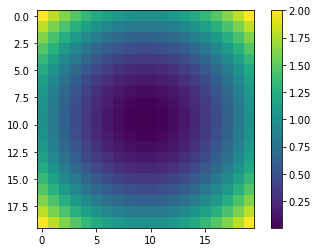

In [5]:
plt.imshow(dist_to_origin)
plt.colorbar()
plt.show()

This is distance to origin that is implemented at the moment.

Example of arbitrary points, drawn using https://www.pixilart.com/draw: ![](20x20dino.png)

In [6]:
dino = 1 - np.array(Image.open("20x20dino.png").convert("L")) / 255

In [7]:
dino.shape

(20, 20)

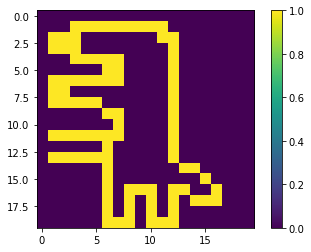

In [8]:
plt.imshow(dino)
plt.colorbar()
plt.show()

Now to calculate distance of every pixel to the closest pixel.

In [26]:
dists = np.full(shape=dino.shape, fill_value=np.nan)

### Naive for-loop

For every pixel in the pixel, find the closest point in the dino image and record distance. 

Mm, makes sense to transform the dino array to a sparse array and iterate over the data points. Should have runtime complexity of `O(h*w*num_ref_points)`, where `h` and `w` is the height and width of the distance matrix, and `num_ref_points` is the number of points in the reference array.

There are a few sparse array formats, of which the COO format is easiest to use for this purpose.

In [27]:
sparse_dino = scipy.sparse.coo_matrix(dino)

In [30]:
for i in range(dists.shape[0]):
    for j in range(dists.shape[1]):
        # Init min dist to closest reference point, as max possible dist
        min_dist = np.linalg.norm([dists.shape[0], dists.shape[1]])
        anchor_point = (np.nan, np.nan)
        # Have checked, NaNs are omitted so below returns all points of interest only
        for ri, rj in zip(sparse_dino.row, sparse_dino.col):
            if np.linalg.norm([i-ri, j-rj]) < min_dist:
                anchor_point = (ri, rj)
                min_dist = np.linalg.norm([i-ri, j-rj])
        
        # Update min_dist in array
        dists[i, j] = min_dist

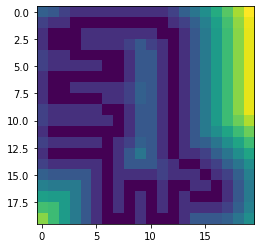

In [31]:
plt.imshow(dists)

<AxesSubplot:>

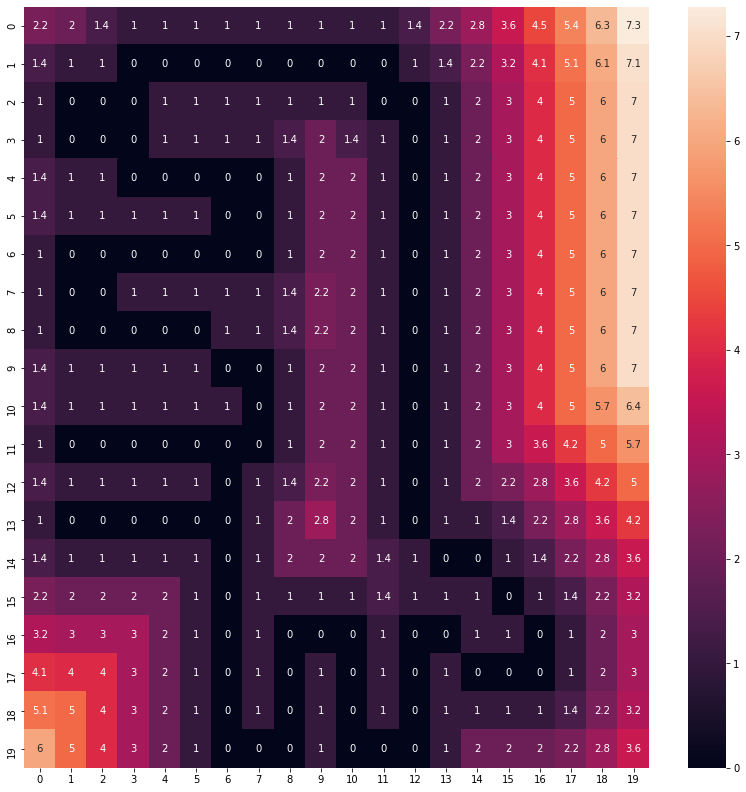

In [32]:
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(dists, annot=True, ax=ax)

Cool, now to package into a function and move on.

In [36]:
def find_min_dist_mat(R: np.ndarray) -> np.ndarray:
    """
    R is reference array
    Returns distance array D
    """
    D = np.full(shape=R.shape, fill_value=np.nan)
    sparse_R = scipy.sparse.coo_matrix(R)
    
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            # Init min dist to closest reference point, as max possible dist
            min_dist = np.linalg.norm([D.shape[0], D.shape[1]])
            anchor_point = (np.nan, np.nan)
            # Have checked, NaNs are omitted so below returns all points of interest only
            for ri, rj in zip(sparse_R.row, sparse_R.col):
                if np.linalg.norm([i-ri, j-rj]) < min_dist:
                    anchor_point = (ri, rj)
                    min_dist = np.linalg.norm([i-ri, j-rj])

            # Update min_dist in array
            D[i, j] = min_dist
    
    return D

### Fitting this into the existing workflow

This feature requires modifying the Net class to handle an extra dim during initialization, and also modifying `create_input` to incorporate the logic.

Doing modification of `create_input` here:

In [35]:
from typing import Optional

In [38]:
def create_input(
    img_width: int,
    img_height: int,
    include_dist_to_origin: bool = True,
    R: Optional[np.ndarray] = None,
    xs_start: float = -1,
    xs_stop: float = 1,
    ys_start: float = -1,
    ys_stop: float = 1,
) -> np.ndarray:
    """
    Creates the input for the generative net.

    Input
    -----
    img_width, img_height: int
    include_dist_to_origin: bool
    R is a reference array that is an extension of include_dist_to_origin

    Output
    ------
    input_arr: np.ndarray
        Should have shape (img_width * img_height, 2)
    """
    if min_dist_matrix is not None:
        assert isinstance(min_dist_matrix, np.ndarray)
        assert min_dist_matrix.shape == (img_width, img_height)
    
    # Create vectors of xs and ys
    xs = np.linspace(start=-1, stop=1, num=img_width)
    ys = np.linspace(start=-1, stop=1, num=img_height)

    # Use np.meshgrid to create a mesh grid
    xv, yv = np.meshgrid(xs, ys)
    input_arr = np.stack((xv, yv), axis=2)
    
    # Reshape input to NN as one row per pixel
    input_arr = input_arr.reshape(img_width * img_height, 2)
    
    if include_dist_to_origin:
        dist_to_origin = np.sum(np.square(input_arr), axis=2, keepdims=True)
        dist_to_origin = dist_to_origin.reshape(img_width * img_height, 1)
        input_arr = np.concatenate([input_arr, dist_to_origin], axis=2)

    if min_dist_mat is not None:
        # Find min_dist_matrix from R, and reformat into correct input shape
        min_dist_mat = find_min_dist_mat(R)
        min_dist_mat = min_dist_mat.reshape(img_width * img_height, 1)
        input_arr = np.concatenate([input_arr, min_dist_mat], axis=2)
        
    return input_arr

Doing the rest of the integration directly in the code base and in a separate POC module.

Implemented, realized that the runtime is a bit too long. Haven't tested that yet here.

In [40]:
smiley = 1 - np.array(Image.open("160x90-smiley.png").convert("L")) / 255

In [56]:
im = Image.open("160x90-smiley.png")

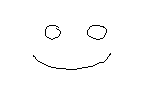

In [57]:
im

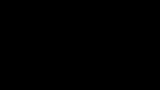

In [58]:
im.convert("L")

The dino PNG had all the blank space explicitly filled with white, this image has not.

In [62]:
im.mode

'RGBA'

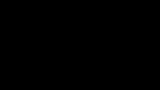

In [63]:
im.convert("RGB")

Hah. Need to handle the alpha channel.

In [65]:
# ref: https://stackoverflow.com/a/33507138/13095028
background = Image.new('RGBA', im.size, (255,255,255))
alpha_composite = Image.alpha_composite(background, im)

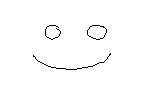

In [67]:
alpha_composite.convert("L")

In [68]:
smiley = 1 - np.array(alpha_composite.convert("L")) / 255

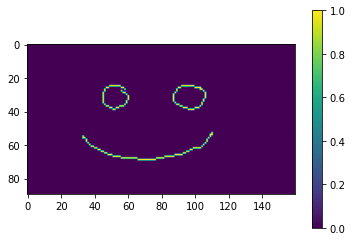

In [69]:
plt.imshow(smiley)
plt.colorbar()

Input issue rectified.

In [87]:
def im_png_to_arr(im):
    # ref: https://stackoverflow.com/a/33507138/13095028
    background = Image.new('RGBA', im.size, (255,255,255))
    alpha_composite = Image.alpha_composite(background, im)
    return 1 - np.array(alpha_composite.convert("L")) / 255

In [88]:
smiley = im_png_to_arr(Image.open("160x90-smiley.png"))

In [78]:
sp_smiley = scipy.sparse.coo_matrix(smiley)

In [80]:
len(sp_smiley.data)

175

175 points total!

In [81]:
D = find_min_dist_mat(smiley)

In [82]:
%%timeit
find_min_dist_mat(smiley)

1min 13s ± 2.95 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [85]:
np.save("160x90-D.npy", D)

Toy problem had 20x20 = 400 points multiplied by <100 points for the dino, so tops out at running logic for 40k times. This image is 160x90=14400 multipled by 175 points = 2.52 mil points. Ehh. Scaling is oof for something beyond toy size.

Easiest way to do this practically is to parallelize the calculations. Algorithmically, a good method is to divide the points into regions designated by quadtrees, so that the points that need to be looked up are drastically less than the whole set. But also thinking of a dynamic programming method to encode distance.